## Accuracy Study of Lossy MFG

We select some non-training nodes in MFG and drop their incoming edges to simulate the effects of node partitioning.

There may be several strategies for choosing those nodes:
* random
* random but excluding important (i.e. high-degree) nodes
* based on the influence score


In [1]:
import sys
sys.path.append("..")
import torch, torch_geometric as pyg
import models.pyg as pyg_models

print("PyTorch:", torch.__version__, *torch.__path__)
print("PyG:", pyg.__version__, *pyg.__path__)
print("CPU parallelism:", torch.get_num_threads())

PyTorch: 2.0.1+cu117 /home/tianhaoh/.local/lib/python3.9/site-packages/torch
PyG: 2.3.1 /home/tianhaoh/.local/lib/python3.9/site-packages/torch_geometric
CPU parallelism: 12


In [49]:
import os
from pathlib import Path
from ogb.nodeproppred import PygNodePropPredDataset
import torch_geometric.transforms as T
from torch_geometric.datasets.amazon import Amazon
from torch_geometric.utils import mask_to_index
from torch_geometric.loader import NeighborLoader, NeighborSampler
from logger import Logger
import pickle

path = Path('/mnt/md0/datasets/')
# name = 'arxiv'
# dataset = PygNodePropPredDataset(
#     root=path, name='ogbn-arxiv',
#     pre_transform=T.ToUndirected(),
#     transform=T.ToSparseTensor()
# )
# data = dataset[0]
# data.NID = torch.arange(0, data.num_nodes, dtype=torch.int32)
# num_classes = dataset.num_classes
# print(data)

name = 'amazon'
dataset = Amazon(path / name, "Computers", pre_transform=T.ToUndirected(), transform=T.ToSparseTensor())
if not hasattr(dataset, name):
    dataset.name = name
data = dataset[0]
data.NID = torch.arange(0, data.num_nodes, dtype=torch.int32)
num_classes = dataset.num_classes
print(data)
# train_nid, val_nid, test_nid = [
#     mask_to_index(mask) for mask in (data.train_mask, data.val_mask, data.test_mask)
# ]
if os.path.exists(f'rand_split_{name}.pt'):
    perm = torch.load(f'rand_split_{name}.pt')
else:
    perm = torch.randperm(data.num_nodes)
    torch.save(perm, f'rand_split_{name}.pt')
train_nid = perm[:data.num_nodes//4]
val_nid = perm[data.num_nodes//2:]
test_nid = perm[data.num_nodes//4:data.num_nodes//2]
print(f"train: {len(train_nid)}, val: {len(val_nid)}, test: {len(test_nid)}")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_layers = 3
num_hidden = 128
fanout = [-1] * num_layers
eval_fanout = [-1] * num_layers
batch_size = 256
n_epochs = 50
n_runs = 5

def get_info():
    return {
        'dataset': dataset.name,
        'num_layers': num_layers, 'num_hidden': num_hidden,
        'fanout': fanout, 'batch_size': batch_size,
        'n_epochs': n_epochs, 'n_runs': n_runs
    }


Data(x=[13752, 767], y=[13752], adj_t=[13752, 13752, nnz=491722], NID=[13752])
train: 3438, val: 6876, test: 3438


In [5]:
from graphutils.rw import lazy_rw

def influential(data, nids, k=3, topk=100):
    init_score = torch.zeros((data.num_nodes,), device=nids.device)
    init_score[nids] = 1 / nids.size(0)
    final_score = lazy_rw(data.adj_t, init_score, k=k)
    topk = final_score.cpu().topk(topk)
    # print("score sum:", final_score.sum(), "topk sum:", topk.values.sum())
    return topk.indices, topk.values

def importance(data, nids, k=3, topk=100):
    init_score = torch.zeros((data.num_nodes,), device=nids.device)
    init_score[nids] = 1 / nids.size(0)
    final_score = torch.zeros_like(init_score)
    score = init_score
    for _ in range(k):
        score = lazy_rw(data.adj_t, score, k=1)
        final_score += score
    topk = (final_score/k).cpu().topk(topk)
    # print("score sum:", final_score.sum(), "topk sum:", topk.values.sum())
    return topk.indices, topk.values

data_cuda = data.cuda()
train_cuda = train_nid.cuda()
train_topk = torch.empty((data.num_nodes, 100), dtype=torch.long)
train_topk_scores = torch.empty((data.num_nodes, 100), dtype=torch.float)
from tqdm import tqdm
for t in tqdm(train_cuda.tolist()):
    t_topk = importance(data_cuda, torch.tensor([t], device='cuda'), k=num_layers, topk=100)
    train_topk[t][:] = t_topk[0]
    train_topk_scores[t][:] = t_topk[1]

train_topk, train_topk_scores = train_topk.cuda(), train_topk_scores.cuda()

100%|██████████| 3438/3438 [00:02<00:00, 1313.25it/s]


In [8]:
train_topk_scores[train_nid[1]].sum()

tensor(0.9296, device='cuda:0')

In [9]:
import tqdm
from pyinstrument import Profiler
import torch.nn.functional as F

# val_dataloader = NeighborLoader(
#     data, num_neighbors=fanout, shuffle=False,
#     input_nodes=val_nid, batch_size=batch_size,
# )
# test_dataloader = NeighborLoader(
#     data, num_neighbors=fanout, shuffle=False,
#     input_nodes=test_nid, batch_size=batch_size,
# )

def train(model, optimizer, dataloader, description='train'):
    model.train()
    # minibatches = tqdm.tqdm(dataloader)
    # minibatches.set_description(description)
    total_loss = total_correct = total_examples = 0
    mfg_sizes = num_nodes = alive_nodes = batch_score = 0
    for batch in dataloader:
        bsize = batch.batch_size
        dev_attrs = [key for key in batch.keys if not key.endswith('_mask')]
        batch = batch.to(device, *dev_attrs, non_blocking=True)
        optimizer.zero_grad()
        y = batch.y[:bsize].long().view(-1)
        y_hat = model(batch.x, batch.adj_t)[:bsize]
        loss = F.nll_loss(y_hat, y)
        loss.backward()
        optimizer.step()
        # collect stats
        total_loss += float(loss) * bsize
        batch_correct = int((y_hat.argmax(dim=-1) == y).sum())
        total_correct += batch_correct
        total_examples += bsize
        mfg_sizes += batch.adj_t.nnz()
        num_nodes += batch.num_nodes
        alive_nodes += batch.alive_nodes
        batch_score += batch.score
    train_acc = total_correct / total_examples
    num_iters = len(dataloader)
    # loss, acc, batch_nodes, rem_nodes, rem_edges, batch_score
    return total_loss / total_examples, train_acc, \
        num_nodes/num_iters, alive_nodes / num_iters, \
        mfg_sizes / num_iters, batch_score / total_examples

@torch.no_grad()
def eval_batch(model, dataloader, description='eval'):
    model.eval()
    minibatches = tqdm.tqdm(dataloader)
    total_loss = total_correct = total_examples = 0
    for batch in minibatches:
        bsize = batch.batch_size
        dev_attrs = [key for key in batch.keys if not key.endswith('_mask')]
        batch = batch.to(device, *dev_attrs, non_blocking=True)
        y = batch.y[:bsize].long().view(-1)
        y_hat = model(batch.x, batch.adj_t)[:bsize]
        loss = F.nll_loss(y_hat, y)
        # collect stats
        total_loss += float(loss) * bsize
        batch_correct = int((y_hat.argmax(dim=-1) == y).sum())
        total_correct += batch_correct
        total_examples += bsize
    train_acc = total_correct / total_examples
    return total_loss / total_examples, train_acc

@torch.no_grad()
def eval_full(model, data, masks, description='eval'):
    model.eval()
    y_hat = model(data.x.cuda(), data.adj_t.cuda())
    out = []
    for mask in masks:
        y = data.y[mask].long().view(-1)
        loss = float(F.nll_loss(y_hat[mask], y))
        acc = int((y_hat[mask].argmax(dim=-1) == y).sum()) / y.shape[0]
        out.append((loss, acc))
    return out


In [10]:
import numpy as np
from torch_sparse import SparseTensor
from torch_geometric.data import Data

# dropping strategies

# random drop node with prob roughly p
def drop_random(batch, p: float) -> Data:
    bn = batch.adj_t.sizes()[0]
    device = batch.adj_t.device()
    node_mask = torch.ones((bn,), dtype=torch.bool, device=device)
    n_drop = int((bn - batch.batch_size) * p)
    if p < 0.25:
        dropped = torch.randint(batch.batch_size, bn, size=(n_drop,), device=device)
    else:
        dropped = torch.randperm(bn-batch.batch_size)[:n_drop] + batch.batch_size
    node_mask[dropped] = False

    n = data.num_nodes
    n_score: torch.Tensor = torch.zeros(n, device=device)
    target_id = batch.n_id[:batch.batch_size]
    topk_nids = train_topk[target_id].view(-1)
    topk_scores = train_topk_scores[target_id].view(-1)
    n_score.scatter_add_(dim=0, index=topk_nids, src=topk_scores)
    n_score = n_score[batch.n_id]
    batch.n_score = n_score

    src, dst, _ = batch.adj_t.coo()
    mask = node_mask[src]
    mask &= node_mask[dst]
    batch.adj_t = SparseTensor(
        row=src[mask], col=dst[mask],
        sparse_sizes=batch.adj_t.sizes(),
        is_sorted=True,
    )
    batch.node_mask = node_mask
    return batch

# drop based on train_topk, train_topk_scores
def drop_by_influence(batch, p: float):
    bn = batch.adj_t.sizes()[0]
    device = batch.adj_t.device()
    node_mask = torch.zeros((bn,), dtype=torch.bool, device=device) 
    n_drop = int((bn - batch.batch_size) * p)

    # select top-k nodes in batch by score
    n = data.num_nodes
    n_score: torch.Tensor = torch.zeros(n, device=device)
    target_id = batch.n_id[:batch.batch_size]
    topk_nids = train_topk[target_id].view(-1)
    topk_scores = train_topk_scores[target_id].view(-1)
    n_score.scatter_add_(dim=0, index=topk_nids, src=topk_scores)
    n_score = n_score[batch.n_id]
    batch.n_score = n_score
    node_mask[n_score.topk(bn-n_drop).indices] = True

    src, dst, _ = batch.adj_t.coo()
    mask = node_mask[dst]
    mask &= node_mask[src]
    batch.adj_t = SparseTensor(
        row=src[mask], col=dst[mask],
        sparse_sizes=batch.adj_t.sizes(),
        is_sorted=True,
    )
    batch.node_mask = node_mask
    return batch

def drop_hop(batch, p: float, hop=1) -> Data:
    '''
    only drop nodes that are not immediate neighbors of target nodes in the mfg
    '''
    def hop_bound(hop_num):
        src, dst, _ = batch.adj_t.coo()
        hop_i = 0
        node_bound = batch.batch_size
        while hop_i < hop_num:
            edge_bound = (src < node_bound).sum().item()
            node_bound = dst[:edge_bound].max().item() + 1
            hop_i += 1
        return node_bound

    bn = batch.adj_t.sizes()[0]
    device = batch.adj_t.device()
    node_mask = torch.ones((bn,), dtype=torch.bool, device=device) 
    n_drop = int((bn - batch.batch_size) * p)

    n_close = hop_bound(hop)
    if n_drop < bn - n_close:
        dropped = torch.randperm(bn-n_close)[:n_drop] + n_close
        node_mask[dropped] = False
    else:
        node_mask[torch.arange(n_close, bn)] = False
        drop_more = n_drop - (bn - n_close)
        dropped = torch.randperm(n_close - batch.batch_size)[:drop_more] + batch.batch_size
        node_mask[dropped] = False

    # select top-k nodes in batch by score
    n = data.num_nodes
    n_score: torch.Tensor = torch.zeros(n, device=device)
    target_id = batch.n_id[:batch.batch_size]
    topk_nids = train_topk[target_id].view(-1)
    topk_scores = train_topk_scores[target_id].view(-1)
    n_score.scatter_add_(dim=0, index=topk_nids, src=topk_scores)
    n_score = n_score[batch.n_id]
    batch.n_score = n_score

    src, dst, _ = batch.adj_t.coo()
    mask = node_mask[dst]
    mask &= node_mask[src]
    batch.adj_t = SparseTensor(
        row=src[mask], col=dst[mask],
        sparse_sizes=batch.adj_t.sizes(),
        is_sorted=True,
    )
    batch.node_mask = node_mask
    return batch

def transform_fn(batch, drop_fn, k=3):
    batch = drop_fn(batch)
    batch.score = batch.n_score[batch.node_mask].sum().item()
    batch.alive_nodes = int(batch.node_mask.sum())
    return batch


In [11]:
# from torch_geometric.utils import degree
# from functools import lru_cache

# data_degrees = degree(data.adj_t.coo()[0], data.num_nodes, dtype=torch.int32)
# @lru_cache
# def topk_degree(topk):
#     return torch.topk(data_degrees, int(topk * data.num_nodes)).values[-1]
# def drop_minor(batch, p: float, topk=0.01) -> Data:
#     '''
#     only drop nodes that are not important, i.e. of low degree
#     '''
#     if p == 0:
#         batch.drop_nodes = 0
#         return batch
#     num_nodes = batch.adj_t.sizes()[0]
#     node_mask = torch.ones((num_nodes,), dtype=torch.bool)
#     drop_nodes = torch.from_numpy(np.random.choice(
#         torch.arange(batch.batch_size, num_nodes).numpy(),
#         size=int((num_nodes - batch.batch_size) * p),
#         replace=False
#     ))
#     node_mask[drop_nodes] = False
#     topk_cutout = topk_degree(topk)
#     node_mask |= (data_degrees[batch.NID.long()] >= topk_cutout)
#     src, dst, _ = batch.adj_t.coo()
#     mask = torch.gather(input=node_mask, dim=0, index=src)
#     mask = mask & torch.gather(input=node_mask, dim=0, index=dst)
#     batch.adj_t = SparseTensor(
#         row=src[mask], col=dst[mask],
#         sparse_sizes=batch.adj_t.sizes(),
#         is_sorted=True
#     )
#     batch.node_mask = node_mask
#     return batch

# def compute_score(batch):
#     '''
#     compute the importance score of each node in the current batch
#     '''
#     num_nodes = batch.num_nodes
#     e_t = torch.zeros((num_nodes,), dtype=torch.float)
#     e_t[:batch.batch_size] = 1
#     deg = degree(batch.adj_t.coo()[0], batch.num_nodes)
#     deg[deg==0] = 1
#     adj = batch.adj_t.t()
#     scores = [e_t]
#     for _ in range(3):
#         pi = scores[-1] / deg
#         scores.append(adj.spmm(pi.view(num_nodes, 1)).view(-1))
#     per_node = sum(scores[1:])
#     return per_node / per_node.sum()

# def transform_fn(batch, drop_fn):
#     score = compute_score(batch)
#     batch = drop_fn(batch)
#     batch.quality_score = score[batch.node_mask].sum().item()
#     batch.alive_nodes = int(batch.node_mask.sum())
#     return batch

In [12]:
def train_with_drop(data, drop_p, fn=drop_random, print_once=False):
    model = pyg_models.SAGE(data.x.shape[1], num_hidden, num_classes, num_layers)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    drop_fn = lambda batch: fn(batch, drop_p)
    transform = lambda batch: transform_fn(batch, drop_fn)
    dataloader = NeighborLoader(
        data, num_neighbors=fanout, shuffle=True,
        input_nodes=train_nid, batch_size=batch_size,
        transform=transform,
        # num_workers=torch.get_num_threads()-2,
        # persistent_workers=True
    )

    logger = Logger(get_info() | {'drop_p': drop_p, "method": fn.__name__})
    print(logger.info)
    for run in range(n_runs):
        logger.set_run(run)
        model.reset_parameters()
        best_val = final_test = 0
        best_epoch = 0
        pbar = tqdm.tqdm(range(n_epochs))
        description = '{:.4f}|{:.4f}|{:.4f}'
        pbar.set_description(f"Run {run}")
        pbar.set_postfix({'acc': description.format(0, best_val, 0)})
        for epoch in pbar:
            # if epoch < 2:
            #     profiler = Profiler()
            #     profiler.start()
            train_loss, train_acc, *info = train(model, optimizer, dataloader, description=f"Epoch {epoch}")
            if print_once:
                # batch_nodes, rem_nodes, rem_edges, batch_score
                print(info)
                print_once = False
            logger.add(epoch, data={'train': {'acc': train_acc, 'loss': train_loss, 'extra': info}})
            val, test = eval_full(model, data, [val_nid, test_nid])
            logger.add(epoch, data={
                'val': {'loss': val[0], 'acc': val[1]},
                'test': {'loss': test[0], 'acc': test[1]},
            })
            if val[1] > best_val:
                best_val, final_test = val[1], test[1]
                best_epoch = epoch
            pbar.set_postfix({'acc': description.format(train_acc, best_val, final_test)})
            # if epoch < 2:
            #     profiler.stop()
            #     profiler.print()
        pbar.close()
        logger.add(epoch, data={'best-epoch': best_epoch})
    # explicitly shutdown workers when persistent_workers is True
    del dataloader._iterator
    return logger

In [13]:
ps = [0.98, 0.95, 0.9, 0.8, 0.7, 0.5, 0]
n_runs = 5
n_epochs = 50
loggers = [train_with_drop(data, drop_p=p, fn=drop_random, print_once=True) for p in ps]
with open(f"{name}_r_drop_random.pkl", "wb") as fp:
    pickle.dump(loggers, fp)

{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.98, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:46,  1.04it/s, acc=0.3083|0.3851|0.3909]

[13333.642857142857, 507.64285714285717, 647.0, 0.3216679713419525]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s, acc=0.9110|0.8807|0.8729]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.95, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:10,  4.59it/s, acc=0.3016|0.3986|0.4072]

[13330.142857142857, 900.1428571428571, 2134.8571428571427, 0.3389543829580044]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s, acc=0.9113|0.8908|0.8802]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.9, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.30it/s, acc=0.3278|0.4079|0.4098]

[13334.857142857143, 1554.9285714285713, 6548.357142857143, 0.36791283505957373]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s, acc=0.9232|0.8931|0.8802]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.8, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:10,  4.76it/s, acc=0.3223|0.3935|0.3976]

[13331.57142857143, 2863.1428571428573, 22671.64285714286, 0.4245138895102474]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s, acc=0.9421|0.9001|0.8935]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.7, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:10,  4.68it/s, acc=0.3482|0.4407|0.4351]

[13332.357142857143, 4172.071428571428, 48131.57142857143, 0.48124999733703505]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.36it/s, acc=0.9404|0.9042|0.8953]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.5, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.10it/s, acc=0.3389|0.3781|0.3807]

[13334.214285714286, 6790.071428571428, 127310.78571428571, 0.5917069322498404]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s, acc=0.9485|0.9018|0.8915]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.35it/s, acc=0.3589|0.4731|0.4674]

[13329.92857142857, 13329.92857142857, 487937.14285714284, 0.8724755957904703]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s, acc=0.9689|0.9065|0.8985]


In [20]:
ps = [0.98, 0.95, 0.9, 0.8, 0.7, 0.5, 0]
n_runs = 5
n_epochs = 50
loggers = [train_with_drop(data, drop_p=p, fn=drop_by_influence, print_once=True) for p in ps]
with open(f"{name}_r_drop_infl.pkl", "wb") as fp:
    pickle.dump(loggers, fp)

{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.98, 'method': 'drop_by_influence'}


Run 0:   2%|▏         | 1/50 [00:00<00:12,  4.00it/s, acc=0.3432|0.3677|0.3720]

[13333.357142857143, 507.7142857142857, 6011.0, 0.4753721313742859]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s, acc=0.9049|0.8867|0.8720]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.95, 'method': 'drop_by_influence'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.44it/s, acc=0.3293|0.3741|0.3773]

[13333.5, 900.4285714285714, 16096.42857142857, 0.571155337277646]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s, acc=0.9252|0.8981|0.8857]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.9, 'method': 'drop_by_influence'}


Run 0:   2%|▏         | 1/50 [00:00<00:10,  4.64it/s, acc=0.3415|0.4132|0.4130]

[13333.285714285714, 1554.857142857143, 36674.0, 0.6688408887684518]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s, acc=0.9488|0.9046|0.8950]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.8, 'method': 'drop_by_influence'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.40it/s, acc=0.3304|0.3684|0.3703]

[13332.214285714286, 2863.285714285714, 89069.42857142857, 0.777982908185656]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s, acc=0.9558|0.9046|0.8962]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.7, 'method': 'drop_by_influence'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.14it/s, acc=0.3281|0.3853|0.3860]

[13332.785714285714, 4172.142857142857, 154004.2857142857, 0.8332407109747105]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s, acc=0.9578|0.9076|0.8997]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.5, 'method': 'drop_by_influence'}


Run 0:   2%|▏         | 1/50 [00:00<00:10,  4.47it/s, acc=0.3226|0.3659|0.3697]

[13331.92857142857, 6788.928571428572, 273763.0, 0.8677739936158434]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.35it/s, acc=0.9602|0.9090|0.9029]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0, 'method': 'drop_by_influence'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.10it/s, acc=0.3487|0.4162|0.4191]

[13331.0, 13331.0, 488708.4285714286, 0.8724756157627073]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s, acc=0.9631|0.9090|0.9026]


In [15]:
ps = [0.98, 0.95, 0.9, 0.8, 0.7, 0.5, 0]
n_runs = 5
n_epochs = 50
loggers = [train_with_drop(data, drop_p=p, fn=drop_hop, print_once=True) for p in ps]
with open(f"{name}_r_drop_hop.pkl", "wb") as fp:
    pickle.dump(loggers, fp)

{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.98, 'method': 'drop_hop'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.38it/s, acc=0.3188|0.3775|0.3822]

[13333.42857142857, 507.7142857142857, 1592.4285714285713, 0.339331843812775]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s, acc=0.9299|0.8922|0.8778]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.95, 'method': 'drop_hop'}


Run 0:   2%|▏         | 1/50 [00:00<00:13,  3.73it/s, acc=0.3357|0.3835|0.3857]

[13329.714285714286, 900.2142857142857, 6356.714285714285, 0.3827978004335733]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s, acc=0.9258|0.8951|0.8825]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.9, 'method': 'drop_hop'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.30it/s, acc=0.3322|0.5350|0.5366]

[13333.214285714286, 1554.857142857143, 20313.428571428572, 0.4565845198794948]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s, acc=0.9378|0.9018|0.8956]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.8, 'method': 'drop_hop'}


Run 0:   2%|▏         | 1/50 [00:00<00:12,  3.80it/s, acc=0.3307|0.4434|0.4418]

[13333.714285714286, 2863.6428571428573, 72151.57142857143, 0.5997941625749322]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s, acc=0.9474|0.9056|0.8973]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.7, 'method': 'drop_hop'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.30it/s, acc=0.3377|0.4609|0.4639]

[13330.214285714286, 4171.357142857143, 148437.07142857142, 0.7384728592034341]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s, acc=0.9613|0.9050|0.8994]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0.5, 'method': 'drop_hop'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.37it/s, acc=0.3566|0.4583|0.4535]

[13332.07142857143, 6789.071428571428, 260773.92857142858, 0.8427244278495571]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.30it/s, acc=0.9593|0.9026|0.9026]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 5, 'drop_p': 0, 'method': 'drop_hop'}


Run 0:   2%|▏         | 1/50 [00:00<00:11,  4.25it/s, acc=0.3287|0.3729|0.3805]

[13328.0, 13328.0, 488089.71428571426, 0.8724756113244324]


Run 4: 100%|██████████| 50/50 [00:11<00:00,  4.25it/s, acc=0.9636|0.9059|0.9011]


In [11]:
ps = [0.9, 0]
n_runs = 1
n_epochs = 50
loggers = [train_with_drop(data, drop_p=p, fn=drop_random, print_once=True) for p in ps]

{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 1, 'drop_p': 0.9, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:13,  3.70it/s, acc=0.3057|0.3743|0.3813]

[13331.785714285714, 1554.5714285714287, 6347.142857142857, 0.2118589995973952]


Run 0: 100%|██████████| 50/50 [00:11<00:00,  4.36it/s, acc=0.9209|0.8946|0.8863]


{'dataset': 'amazon', 'num_layers': 3, 'num_hidden': 128, 'fanout': [-1, -1, -1], 'batch_size': 256, 'n_epochs': 50, 'n_runs': 1, 'drop_p': 0, 'method': 'drop_random'}


Run 0:   2%|▏         | 1/50 [00:00<00:10,  4.48it/s, acc=0.3476|0.4853|0.4791]

[13330.857142857143, 13330.857142857143, 488500.5, 0.7559828189585777]


Run 0: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s, acc=0.9642|0.9062|0.9029]


In [69]:
def stdmean(logger: Logger, *labels, summarize=None):
    '''
    compute the stdmean of logged data with the given labels across all runs
    customized by the `summarize` fn
    '''
    if summarize is None:
        summarize = lambda x: x
    series_dict = {}
    for run in logger:
        run_dict = logger.get_data(run, *labels)
        summary_dict = summarize(run_dict)
        for new_label in summary_dict:
            if new_label not in series_dict:
                series_dict[new_label] = []
            series_dict[new_label].append(summary_dict[new_label])
    stdmean_dict = {}
    for label in series_dict:
        t = torch.tensor(series_dict[label])
        stdmean_dict[label] = [t.mean().item(), t.std().item()]
    return stdmean_dict

def stdmean_acc(logger: Logger):
    def get_acc(val_test):
        val_acc = 100 * torch.tensor(val_test['val/acc'])
        valid = val_acc.max().item()
        test = 100 * val_test['test/acc'][val_acc.argmax()]
        return {'val/acc' : valid, 'test/acc': test}
    return stdmean(logger, 'val/acc', 'test/acc', summarize=get_acc)

import pickle
loggers = {}
name = 'amazon'
with open(f'{name}_r_drop_random.pkl', 'rb') as fp:
    loggers['random'] = pickle.load(fp)
with open(f'{name}_r_drop_infl.pkl', 'rb') as fp:
    loggers['influence'] = pickle.load(fp)
with open(f'{name}_r_drop_hop.pkl', 'rb') as fp:
    loggers['neighbor'] = pickle.load(fp)


def extract_train_info(train_extra):
    ext_list = list(zip(*train_extra['train/extra']))
    # batch_nodes, rem_nodes, rem_edges, batch_score
    return {
        # 'batch_nodes': ext_list[0],
        'rem_nodes': ext_list[1],
        'rem_edges': ext_list[2],
        'coverage': ext_list[3],
    }

proc_data = {}
for method, loggers in loggers.items():
    proc_data[method] = {
        k: [] for k in
        ('p', 'train/acc', 'val/acc', 'test/acc', 'rem_nodes', 'rem_edges', 'coverage')
    }
    m_data = proc_data[method]
    for logger in loggers:
        info = logger.info.copy()
        m_data['p'].append(info['drop_p'])
        acc = stdmean_acc(logger)
        for k in acc:
            m_data[k].append(acc[k])
        train_acc = stdmean(logger, 'train/acc',
            summarize=lambda x: {k: 100*max(v) for k, v in x.items()})
        for k in train_acc:
            m_data[k].append(train_acc[k])
        train_stat = stdmean(logger, 'train/extra', summarize=extract_train_info)
        for k in train_stat:
            m_data[k].append(train_stat[k])


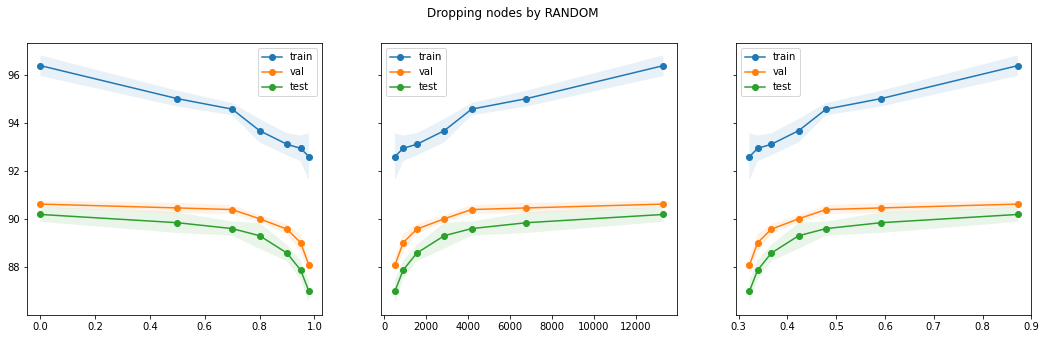

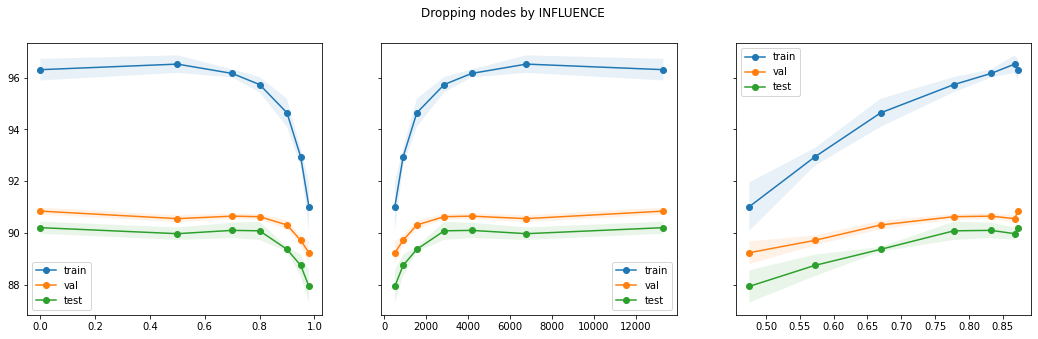

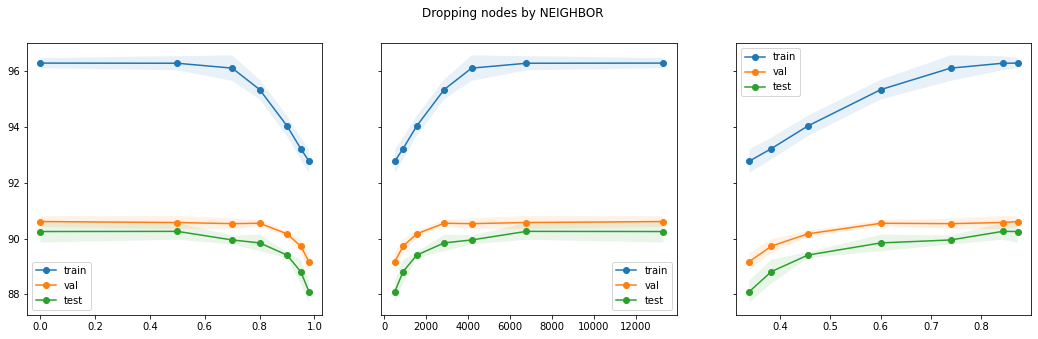

In [17]:
import matplotlib.pyplot as plt

for _, method in enumerate(proc_data):
    m_data = proc_data[method]
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    plt.suptitle(f"Dropping nodes by {method.upper()}")
    # plt.ylim([55, 75])
    for i, xlabel in enumerate(['p', 'rem_nodes', 'coverage']):
        for k in ('train/acc', 'val/acc', 'test/acc'):
            if isinstance(m_data[xlabel][0], list) or isinstance(m_data[xlabel][0], list):
                xs = list(zip(*m_data[xlabel]))[0]
            else:
                xs = m_data[xlabel]
            mean, std = [torch.tensor(a) for a in zip(*m_data[k])]
            axs[i].plot(xs, mean, marker='o', label=k.split('/')[0])
            axs[i].fill_between(xs, mean-std, mean+std, alpha=0.1, interpolate=True)
            axs[i].legend()
plt.show()

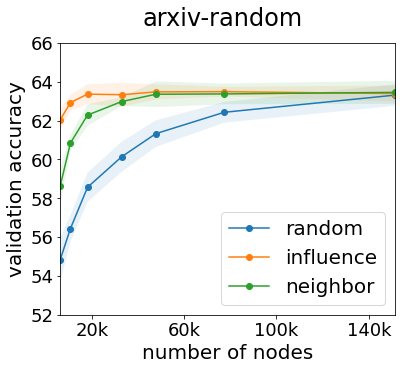

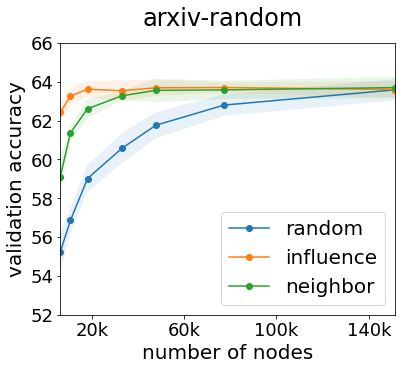

In [72]:
for metric, ylim in (('val/acc', None), ('test/acc', None)):
    # data = proc_data[method]
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    axs = [ax]
    plt.suptitle(f"{name}-random", fontsize=24)
    if ylim is not None:
        plt.ylim(ylim)
    for i, xlabel in enumerate(['rem_nodes']): # , 'coverage']):
        # for k in ('train/acc', 'val/acc', 'test/acc'):
        for k in proc_data:
            k_data = proc_data[k]
            if isinstance(k_data[xlabel][0], list) or isinstance(k_data[xlabel][0], list):
                xs = list(zip(*k_data[xlabel]))[0]
            else:
                xs = k_data[xlabel]
            mean, std = [torch.tensor(a) for a in zip(*k_data[metric])]

            if xs[0] > xs[1]:
                xs = list(reversed(xs))
                mean = reversed(mean)
                std = reversed(std)
            # xs, mean, std = xs[1:], mean[1:], std[1:]

            axs[i].plot(xs, mean, marker='o', label=k.split('/')[0])
            axs[i].fill_between(xs, mean-std, mean+std, alpha=0.1, interpolate=True)
            axs[i].autoscale(enable=True, axis='x', tight=True)
            axs[i].set_xlabel('number of nodes' if xlabel == 'rem_nodes' else xlabel, fontsize=20)
            xticks = axs[i].get_xticks()
            if xlabel == 'rem_nodes':
                steps = len(xticks) // 4
                xticks = xticks[::steps]
                axs[i].set_xticks(xticks)
                axs[i].set_xticklabels([f"{int(tick/1000)}k" for tick in xticks])
            yticks = axs[i].get_yticks()
            new_yticks = []
            for ytick in yticks:
                if int(ytick) == ytick:
                    new_yticks.append(int(ytick))
            axs[i].set_yticks(new_yticks)
            axs[i].tick_params(axis='y', which='major', labelsize=18)
            axs[i].tick_params(axis='x', which='major', labelsize=18)
            if i == 0:
                axs[i].set_ylabel('validation accuracy', fontsize=20)
    axs[i].legend(fontsize=20, loc='lower right')
    
    if 'train' not in metric:
        plt.savefig(f"{name}_r_drop_{metric.replace('/', '_')}.pdf", dpi=160, bbox_inches='tight')
plt.show()

In [7]:
iterator = iter(NeighborLoader(
    data, num_neighbors=[-1]*3, shuffle=False,
    input_nodes=train_nid, batch_size=batch_size,
    num_workers=0
))
batch = next(iterator)

In [31]:
num_nodes = batch.num_nodes
e_t = torch.zeros((num_nodes,), dtype=torch.float)
e_t[:batch.batch_size] = 1
print(batch)
deg = degree(batch.adj_t.coo()[0], batch.num_nodes)
deg[deg==0] = 1
adj = batch.adj_t.t()

for num_layers in range(2, 8):
    scores = [e_t]
    for k in range(num_layers):
        pi = scores[-1] / deg
        scores.append(adj.spmm(pi.view(num_nodes, 1)).view(-1))

    per_node = sum(scores[1:])
    per_node[:batch.batch_size] = 0
    topk = torch.topk(per_node, k=batch.batch_size*4)
    nid = torch.sort(topk.indices).values
    topk_sum = topk.values.sum().item()
    all_sum = per_node.sum().item()

    src, dst, _ = batch.adj_t.coo()
    hop1 = dst[src<batch.batch_size]
    hop1_max = dst[src==batch.batch_size-1].max().item()
    assert hop1.max().item() == hop1_max
    topk = nid.shape[0]
    in_hop1 = (nid <= hop1_max).sum().item()
    print(f"num_layers={num_layers}")
    print(f"{in_hop1}/{topk}={in_hop1/topk*100:.2f}%; {topk_sum:.0f}/{all_sum:.0f}")

Data(num_nodes=144436, x=[144436, 128], node_year=[144436, 1], y=[144436, 1], adj_t=[144436, 144436, nnz=2047267], NID=[144436], input_id=[1024], batch_size=1024)
num_layers=2
3417/4096=83.42%; 1101/1863
num_layers=3
3423/4096=83.57%; 1502/2865
num_layers=4
3218/4096=78.56%; 1732/3688
num_layers=5
3185/4096=77.76%; 2008/4512
num_layers=6
3103/4096=75.76%; 2205/5226
num_layers=7
3066/4096=74.85%; 2420/5922


In [47]:
dataloader = iter(NeighborLoader(
    data, num_neighbors=[-1,-1], shuffle=False,
    input_nodes=train_nid, batch_size=batch_size,
    num_workers=0
))
# next(dataloader)
batch = next(dataloader)

In [21]:
drop_random.__name__

'drop_random'